In [12]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
# Binary parameters (Zuniga-Fernandez et al. 2021)

t_ref = 2023                        # t_ref = T0_AB

fA_i = 0.87 + 0.13                     # incident flux

e_B = 0.805
i_B = np.radians(66.3)
a_B = 1.01
m_Ba = 0.77
m_Bb = 0.62
omega_Ba = np.radians(104.5)
omega_Bb = omega_Ba - np.pi
Omega_B = np.radians(342.7)
T0_B = 48707.5
P_B = 314.86
mean_B = np.radians(360*(t_ref - T0_B)/P_B)
flux_ratio_B = 70

e_A = 0.4808
i_A = np.radians(135.6)
a_A = 0.86
m_Aa = 0.93
m_Ab = 0.29
omega_Aa = np.radians(68.7)
omega_Ab = omega_Aa - np.pi
Omega_A = np.radians(170.2)
T0_A = 48742.5
P_A = 264.51
mean_A = np.radians(360*(t_ref - T0_A)/P_A)
flux_ratio_A = 15

e_AB = 0.46
i_AB = np.radians(88.1)
a_AB = 51
m_A = 1.1
m_B = 1.4
omega_A = np.radians(65)
omega_B = omega_A - np.pi
Omega_AB = np.radians(184.5)
T0_AB = 2023
P_AB = 230
mean_AB = np.radians(360*(t_ref - T0_AB)/P_AB)


# Disk parameters (Kennedy et al. 2019)

a_inner = 2.5
a_outer = 4.6
e_disk = 0.03
pos_disk = np.radians(15.6)         # Omega
inc_disk = np.radians(26)
omega_disk = np.radians(-73)
b_inner = a_inner*np.cos(inc_disk)*(1-e_disk**2)**0.5
b_outer = a_outer*np.cos(inc_disk)*(1-e_disk**2)**0.5


In [14]:
# Build disk

angles = np.linspace(0, 2*np.pi, 100)

x_outer = a_outer*np.cos(angles)
y_outer = b_outer*np.sin(angles)
z_outer = x_outer*np.tan(inc_disk)

x_inner = a_inner*np.cos(angles)
y_inner = b_inner*np.sin(angles)
z_inner = x_inner*np.tan(inc_disk)

# Rotate disk
x_o = x_outer*np.cos(pos_disk) - y_outer*np.sin(pos_disk)
y_o = x_outer*np.sin(pos_disk) + y_outer*np.cos(pos_disk)
x_i = x_inner*np.cos(pos_disk) - y_inner*np.sin(pos_disk)
y_i = x_inner*np.sin(pos_disk) + y_inner*np.cos(pos_disk)

x_inner = x_i
y_inner = y_i
x_outer = x_o
y_outer = y_o

In [19]:
# Create 3 star system - Ba + Bb + A

# Create system B (Ba + Bb)

sim = rebound.Simulation()
sim.units = ('days', 'AU', 'Msun')
sim.move_to_hel()

Ba = rebound.Particle(simulation=sim,
                      m=m_Ba,
                     )


Bb = rebound.Particle(simulation=sim,
                      primary=Ba,
                      m=m_Bb,
                      a=a_B,
                      e=e_B,
                      omega=omega_Bb,
                      inc=i_B,
                      Omega=Omega_B
                     )



sim.add(Ba)
sim.add(Bb)
sim.move_to_com()
Ba, Bb = sim.particles


# Create AaAb as a single object representing the CoM of AaAb relative to the CoM of BaBb

A = rebound.Particle(simulation=sim,
                     m=m_A,
                     a=a_AB,
                     e=e_AB,
                     omega=omega_A,
                     inc=i_AB,
                     Omega=Omega_AB
                    )


sim.add(A)



In [29]:
# Plot orbits

start_time = 0
t_max = 18*365.25 + start_time   # integrate over 18 years
n_steps = int(1e4)
times = np.linspace(start_time, t_max, n_steps)

# Initialise arrays for the orbital parameters of the four stars

x_A, y_A, z_A = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)  
x_Ba, y_Ba, z_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
x_Bb, y_Bb, z_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)


vx_A, vy_A, vz_A = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ba, vy_Ba, vz_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Bb, vy_Bb, vz_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)

x_transits = []
y_transits = []

flux_A = np.zeros(n_steps)


Ba, Bb, A = sim.particles

for i, t in enumerate(times):
    sim.integrate(t)

    # Calculate the CoM of Ba and Bb
    comB = sim.calculate_com(first=0, last=2)     
    pos_comB = np.array([comB.x, comB.y, comB.z])
    v_comB = np.array([comB.vx, comB.vy, comB.vz])
    
    # Recenter all components so the CoM of BaBb is at the origin
    x_Ba[i], y_Ba[i], z_Ba[i] = np.array([Ba.x, Ba.y, Ba.z]) - pos_comB
    x_Bb[i], y_Bb[i], z_Bb[i] = np.array([Bb.x, Bb.y, Bb.z]) - pos_comB
    vx_Ba[i], vy_Ba[i], vz_Ba[i] = np.array([Ba.vx, Ba.vy, Ba.vz]) - v_comB
    vx_Bb[i], vy_Bb[i], vz_Bb[i] = np.array([Bb.vx, Bb.vy, Bb.vz]) - v_comB
    
    x_A[i], y_A[i], z_A[i] = np.array([A.x, A.y, A.z]) - pos_comB
    vx_A[i], vy_A[i], vz_A[i] = np.array([A.vx, A.vy, A.vz]) - v_comB
    
    # Rotate disk and A to y=0 to determine when transit is happening     
    x, y = x_A[i], y_A[i]
    r = (x**2 + y**2)**0.5      # x=r, y=0 after rotation
    theta = np.arctan(y/x)
        
    phi = pos_disk - theta    # effective position angle of disk (in relation to A)
    
    F_inner = (a_inner**2)*(b_inner**2)
    F_outer = (a_outer**2)*(b_outer**2)
    A_inner =  (a_inner**2)*(np.sin(phi)**2) + (b_inner**2)*(np.cos(phi)**2)
    A_outer =  (a_outer**2)*(np.sin(phi)**2) + (b_outer**2)*(np.cos(phi)**2)
    
    
    x_inner2 =  (F_inner/A_inner)**0.5
    x_outer2 = (F_outer/A_outer)**0.5
        
    # Calculate distance to particle in disk plane
    yp = r*np.cos(phi)/np.cos(inc_disk)
    xp = r*np.sin(phi)
    rp = (xp**2 + yp**2)**0.5
    
    xp_inner = abs(r*np.sin(phi))

    tau_disk = 0.5*xp_inner/rp
    
    # Calculating flux during transit
    fA_t = fA_i*np.exp(-tau_disk)   

    if x_inner2 < r < x_outer2:
        x_transits.append(x_A[i])
        y_transits.append(y_A[i])
        flux_A[i] = fA_t
    else:
        flux_A[i] = fA_i
        
    

0.05510426675872516
0.05509191722132757
0.05507955980552993
0.05506719450346538
0.05505482130724434
0.05504244020895432
0.05503005120066129
0.055017654274411576
0.055005249422233865
0.054992836636141136
0.05498041590813251
0.05496798723019456
0.05495555059430262
0.054943105992421595
0.054930653416506804
0.05491819285850451
0.05490572431035231
0.05489324776397964
0.054880763211307866
0.054868270644250434
0.05485577005471326
0.05484326143459446
0.05483074477578472
0.054818220070167116
0.054805687309617254
0.05479314648600312
0.05478059759118517
0.05476804061701627
0.05475547555534161
0.054742902397998706
0.054730321136817285
0.05471773176361924
0.054705134270218635
0.05469252864842151
0.054679914890025924
0.054667292986821825
0.05465466293059101
0.054642024713107
0.054629378326135035
0.05461672376143198
0.05460406101074619
0.054591390065817584
0.05457871091837735
0.05456602356014813
0.05455332798284374
0.054540624178169225
0.05452791213782071
0.05451519185348543
0.05450246331684153
0.054

0.0392487776571655
0.03922397490542073
0.039199148992941635
0.03917429988644898
0.039149427552601535
0.03912453195799595
0.03909961306916674
0.039074670852586264
0.03904970527466477
0.03902471630175028
0.03899970390012873
0.03897466803602382
0.03894960867559722
0.03892452578494842
0.038899419330114926
0.03887428927707216
0.03884913559173364
0.03882395823995107
0.038798757187514306
0.038773532400151585
0.03874828384352954
0.03872301148325353
0.03869771528486753
0.03867239521385453
0.03864705123563672
0.03862168331557567
0.03859629141897259
0.038570875511068664
0.038545435557045385
0.03851997152202491
0.038494483371070476
0.038468971069186855
0.03844343458132093
0.0384178738723621
0.03839228890714308
0.03836667965044042
0.03834104606697534
0.03831538812141443
0.038289705778370466
0.03826399900240327
0.03823826775802049
0.038212512009678214
0.03818673172178164
0.038160926858685
0.03813509738469126
0.03810924326405072
0.03808336446095848
0.038057460939550244
0.0380315326638966
0.0380055795

0.0022444223141998947
0.0021726317445038335
0.0021007263152637108
0.002028705752582242
0.001956569781702851
0.0018843181270062099
0.0018119505120073023
0.0017394666593517165
0.0016668662908125593
0.0015941491272870741
0.001521314888793182
0.0014483632944661496
0.0013752940625552834
0.0013021069104204213
0.0012288015545285787
0.0011553777104504183
0.0010818350928569185
0.001008173415515871
0.0009343923912883262
0.0008604917321251667
0.0007864711490636521
0.0007123303522237701
0.0006380690508046326
0.0005636869530813018
0.0004891837664006639
0.00041455919717835416
0.00033981295089475957
0.0002649447320917432
0.00018995424436859835
0.00011484119037879962
3.960527182613226e-05
3.575381053902902e-05
0.00011123635692329066
0.00018684266849396022
0.0002625730473829898
0.00033842779669042064
0.00041440722048830014
0.0004905116238245746
0.0005667413127267054
0.0006430965942054109
0.0007195777762588804
0.0007961851678761894
0.0008729190790413398
0.000949779820737171
0.0010267677049492488
0.00110

0.2990039582735279
0.30000930702733497
0.3010174596967435
0.30202840326290925
0.3030421242059995
0.30405860849723504
0.30507784159088036
0.30609980841618123
0.3071244933692523
0.3081518803049171
0.3091819525285044
0.31021469278759783
0.31125008326374753
0.31228810556414105
0.3133287407132398
0.3143719691443811
0.31541777069135013
0.3164661245799246
0.31751700941939354
0.3185704031940559
0.3196262832546996
0.3206846263100675
0.3217454084183097
0.32280860497842995
0.32387419072172763
0.324942139703239
0.32601242529318314
0.32708502016841656
0.32815989630389913
0.32923702496417784
0.33031637669489244
0.33139792131430573
0.3324816279048686
0.3335674648048177
0.3346553995998169
0.3357453991146451
0.3368374294049368
0.33793145574897976
0.3390274426395785
0.34012535377598613
0.341225152055913
0.34232679956761763
0.3434302575820863
0.3445354865453089
0.3456424460706563
0.3467510949313664
0.34786139105314845
0.34897329150690876
0.35008675250160876
0.3512017293772606
0.3523181765980703
0.3534360

0.20084130743656475
0.20072380350485164
0.20060653519875826
0.20048950183202746
0.20037270272094926
0.20025613718435098
0.2001398045435852
0.20002370412251974
0.19990783524752592
0.19979219724746852
0.19967678945369394
0.19956161120002056
0.19944666182272705
0.1993319406605426
0.1992174470546354
0.19910318034860283
0.19898913988846034
0.19887532502263153
0.19876173510193731
0.1986483694795858
0.19853522751116168
0.1984223085546163
0.19830961197025712
0.19819713712073772
0.19808488337104777
0.1979728500885023
0.19786103664273275
0.19774944240567588
0.19763806675156456
0.19752690905691744
0.19741596870052952
0.19730524506346173
0.19719473752903183
0.19708444548280413
0.19697436831258044
0.19686450540838957
0.1967548561624787
0.19664541996930304
0.1965361962255171
0.19642718432996445
0.19631838368366902
0.19620979368982516
0.19610141375378887
0.19599324328306786
0.19588528168731326
0.19577752837830967
0.19566998276996594
0.19556264427830694
0.19545551232146344
0.19534858631966423
0.195241

0.13847059306458082
0.13844577479002027
0.13842097974992057
0.13839620791127716
0.13837145924114866
0.13834673370665684
0.13832203127498682
0.13829735191338624
0.13827269558916583
0.13824806226969866
0.1382234519224204
0.13819886451482893
0.13817430001448439
0.13814975838900873
0.13812523960608608
0.1381007436334619
0.13807627043894352
0.13805181999039953
0.13802739225575986
0.13800298720301554
0.1379786048002185
0.13795424501548167
0.1379299078169786
0.13790559317294326
0.1378813010516702
0.13785703142151426
0.13783278425089018
0.13780855950827284
0.13778435716219684
0.1377601771812566
0.13773601953410602
0.13771188418945832
0.13768777111608613
0.13766368028282114
0.13763961165855396
0.13761556521223411
0.13759154091286982
0.13756753872952784
0.13754355863133327
0.13751960058746973
0.13749566456717865
0.13747175053975988
0.13744785847457064
0.13742398834102626
0.1374001401085995
0.13737631374682063
0.13735250922527723
0.13732872651361394
0.13730496558153266
0.13728122639879203
0.13725

0.12008040586096194
0.12006969669952604
0.12005899393429047
0.12004829755936768
0.1200376075688764
0.12002692395694188
0.12001624671769581
0.1200055758452762
0.11999491133382736
0.1199842531775
0.11997360137045093
0.11996295590684325
0.11995231678084617
0.11994168398663499
0.11993105751839107
0.11992043737030184
0.11990982353656061
0.11989921601136656
0.1198886147889248
0.11987801986344619
0.11986743122914738
0.11985684888025058
0.11984627281098376
0.11983570301558037
0.1198251394882794
0.11981458222332514
0.1198040312149675
0.11979348645746152
0.11978294794506747
0.11977241567205088
0.11976188963268221
0.11975136982123717
0.11974085623199614
0.11973034885924456
0.11971984769727256
0.11970935274037502
0.11969886398285144
0.11968838141900584
0.11967790504314665
0.11966743484958678
0.11965697083264346
0.11964651298663807
0.1196360613058962
0.11962561578474769
0.11961517641752635
0.1196047431985702
0.11959431612222135
0.11958389518282607
0.11957348037473513
0.11956307169230382
0.119552669

0.11126913140569329
0.11126296334945121
0.11125679797060431
0.11125063526724034
0.11124447523744875
0.11123831787932087
0.1112321631909499
0.1112260111704308
0.11121986181586055
0.11121371512533784
0.11120757109696339
0.11120142972883966
0.1111952910190711
0.11118915496576401
0.11118302156702661
0.11117689082096908
0.11117076272570343
0.11116463727934366
0.11115851448000563
0.11115239432580717
0.11114627681486812
0.1111401619453101
0.11113404971525685
0.11112794012283395
0.11112183316616893
0.11111572884339138
0.11110962715263274
0.1111035280920265
0.1110974316597081
0.11109133785381489
0.11108524667248632
0.11107915811386367
0.11107307217609033
0.11106698885731155
0.11106090815567482
0.11105483006932923
0.11104875459642624
0.11104268173511907
0.11103661148356306
0.11103054383991547
0.11102447880233557
0.11101841636898477
0.1110123565380262
0.1110062993076253
0.11100024467594935
0.11099419264116768
0.11098814320145163
0.11098209635497457
0.11097605209991185
0.11097001043444078
0.110963

0.10676258974358496
0.10675819107515694
0.10675379395585272
0.10674939838476705
0.10674500436099416
0.10674061188362784
0.10673622095176133
0.10673183156448755
0.10672744372089897
0.10672305742008789
0.10671867266114643
0.10671428944316694
0.10670990776524211
0.10670552762646539
0.10670114902593157
0.10669677196273746
0.1066923964359825
0.10668802244476984
0.10668364998820719
0.10667927906540767
0.10667490967549004
0.10667054181757886
0.10666617549080343
0.106661810694297
0.10665744742719496
0.10665308568863391
0.10664872547775044
0.10664436679368039
0.10664000963555842
0.10663565400251755
0.10663129989368918
0.1066269473082029
0.10662259624518654
0.10661824670376632
0.10661389868306681
0.10660955218221112
0.10660520720032096
0.10660086373651674
0.10659652178991776
0.10659218135964214
0.10658784244480723
0.10658350504452939
0.10657916915792413
0.10657483478410644
0.10657050192219064
0.10656617057129045
0.10656184073051916
0.10655751239898976
0.10655318557581481
0.10654886026010657
0.10

0.10255021829252632
0.10254714173231926
0.10254406602111936
0.10254099115851881
0.10253791714411034
0.10253484397748713
0.10253177165824291
0.10252870018597174
0.10252562956026832
0.10252255978072766
0.1025194908469454
0.10251642275851756
0.1025133555150407
0.10251028911611174
0.10250722356132819
0.10250415885028796
0.10250109498258946
0.10249803195783161
0.10249496977561373
0.1024919084355356
0.10248884793719756
0.10248578828020033
0.10248272946414519
0.10247967148863375
0.10247661435326817
0.10247355805765111
0.1024705026013856
0.10246744798407521
0.10246439420532395
0.1024613412647363
0.1024582891619172
0.10245523789647198
0.10245218746800655
0.10244913787612715
0.10244608912044063
0.10244304120055414
0.10243999411607539
0.10243694786661252
0.10243390245177411
0.10243085787116918
0.10242781412440725
0.10242477121109825
0.1024217291308526
0.10241868788328108
0.10241564746799509
0.10241260788460625
0.10240956913272686
0.10240653121196949
0.10240349412194721
0.10240045786227363
0.10239

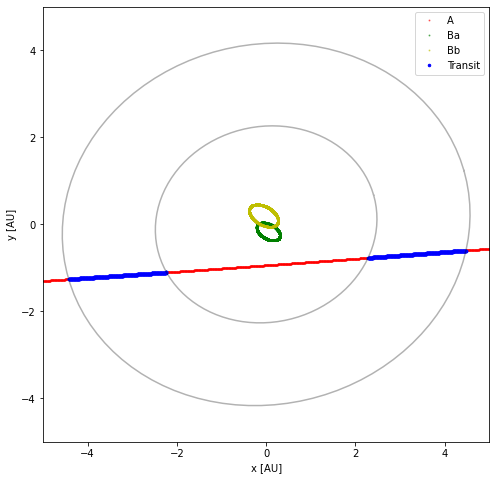

In [23]:
# Make 2D plot
fig1 = plt.figure(1, figsize=(8,8))

plt.plot(x_A, y_A, 'r.', alpha = 0.5, markersize=2, label='A', figure=fig1)
plt.plot(x_Ba, y_Ba, 'g.', alpha = 0.5, markersize=2, label='Ba', figure=fig1)
plt.plot(x_Bb, y_Bb, 'y.', alpha = 0.5, markersize=2, label='Bb', figure=fig1)
plt.plot(x_transits, y_transits, 'b.', markersize=5, label = 'Transit', figure=fig1)

plt.plot(x_inner, y_inner, 'k', alpha=0.3)
plt.plot(x_outer, y_outer, 'k', alpha=0.3)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()

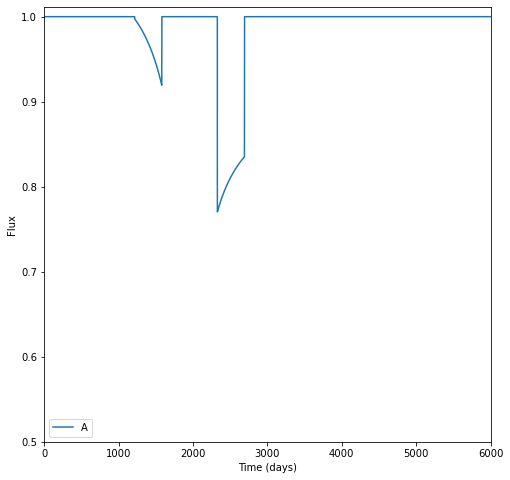

In [31]:
# Plot lightcurve during transit
fig2 = plt.figure(2, figsize=(8,8))

plt.plot(times, flux_A, label = 'A', figure=fig2)
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.xlim(0,6000)
plt.ylim(0.5,)
plt.legend()